# Entrega 4 - Redes Neuronales

### Grupo 9:
     - J. Gu       C.I 5.509.557-9
     - M. Nuñez    C.I 5.225.262-3
     - L. Pereira  C.I 5.268.309-4



## 1. Objetivo

El objetivo de esta tarea es implementar y evaluar distintos modelos basados en redes neuronales y regresión logística, compararlos entre sí y con los modelos realizados en laboratorios anteriores para sacar conclusiones sobre su desempeño. 

El éxito del aprendizaje se mide a través de los valores de accuracy, precisión, recall y f1. Analizaremos los valores de cada uno de los modelos generados y compararemos cual se desempeño mejor.


## 2. Diseño

En esta sección, dado que el diseño de los modelos 1 a 4 que había que implementar venía dado por la letra, para dichos modelos solamente aclararemos las consideraciones que tuvimos. Con respecto al modelo 5 y las 3 alternativas planteadas si aclararemos los detalles del diseño.

Para la implementación de todos los modelos nos basamos fuertemente en el teórico dado en el curso y en la documentación de pytorch. En específico a la documentación brindad en este link: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
DATASET_FILE = 'lab4_dataset.csv'
dataset = pd.read_csv(DATASET_FILE, sep=",")
dataset = dataset.drop(columns=['time'])

print("Separando el conjunto de datos en conjunto de entrenamiento y conjunto de prueba...")
# Dividir el conjunto de datos en conjunto de entrenamiento (80%) y conjunto de prueba (20%)
train_full, test = train_test_split(dataset, test_size=0.2, random_state=42)

# Dividir el conjunto de entrenamiento completo en conjunto de entrenamiento (90%) y validación (10%)
train, validation = train_test_split(train_full, test_size=0.1, random_state=42)

# Separar características (X) y etiquetas (y) para el conjunto de entrenamiento y validación
X_train = train.drop(columns=['cid'])  
y_train = train['cid']

X_val = validation.drop(columns=['cid'])
y_val = validation['cid']


Separando el conjunto de datos en conjunto de entrenamiento y conjunto de prueba...


### Modelo 1

In [3]:
print("Entrenando modelo de regresión logística...")

# Crear el modelo de regresión logística
model = LogisticRegression(max_iter=3000)

# Entrenar el modelo con el conjunto de entrenamiento
model.fit(X_train, y_train)

# Predecir las etiquetas del conjunto de validación
y_pred = model.predict(X_val)

# Calcular la accuracy en el conjunto de validación
accuracy = accuracy_score(y_val, y_pred)

print(f'Accuracy del modelo de regresión logística: {accuracy:.4f}')

Entrenando modelo de regresión logística...
Accuracy del modelo de regresión logística: 0.8023


c:\Users\lpereira\Documents\GitHub\AA-2024\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Modelo 2

In [4]:
# Definir el modelo con una sola neurona lineal y dos salidas (para 2 clases)
class SimpleNN(nn.Module):
    def __init__(self, features):
        super(SimpleNN, self).__init__()
        self.linear = nn.Linear(features, 2)  #features es el número de características

    def forward(self, x):
        return self.linear(x)

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()  # Modo de entrenamiento
    train_loss = 0
    correct = 0

    for batch, (X, y) in enumerate(dataloader):
        # Forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backward pass y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calcular métricas
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Promedio de pérdida y precisión
    train_loss /= len(dataloader)
    correct /= size
    return train_loss, correct


In [6]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()  # Modo de evaluación
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Promedio de pérdida y precisión
    test_loss /= num_batches
    correct /= size
    return test_loss, correct

In [7]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Escalar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.int64)

dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
dataset_val = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 32
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

# Crear la red neuronal
model = SimpleNN(X_train_tensor.shape[1])

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

Epoch [10/100], Loss: 0.6606, Train Accuracy: 0.6004, Val Loss: 0.7048, Val Accuracy: 0.5291
Epoch [20/100], Loss: 0.5905, Train Accuracy: 0.7005, Val Loss: 0.6351, Val Accuracy: 0.6279
Epoch [30/100], Loss: 0.5509, Train Accuracy: 0.7440, Val Loss: 0.5940, Val Accuracy: 0.6860
Epoch [40/100], Loss: 0.5231, Train Accuracy: 0.7596, Val Loss: 0.5656, Val Accuracy: 0.7151
Epoch [50/100], Loss: 0.5110, Train Accuracy: 0.7726, Val Loss: 0.5470, Val Accuracy: 0.7384
Epoch [60/100], Loss: 0.5032, Train Accuracy: 0.7797, Val Loss: 0.5335, Val Accuracy: 0.7384
Epoch [70/100], Loss: 0.4941, Train Accuracy: 0.7830, Val Loss: 0.5234, Val Accuracy: 0.7442
Epoch [80/100], Loss: 0.4900, Train Accuracy: 0.7836, Val Loss: 0.5161, Val Accuracy: 0.7442
Epoch [90/100], Loss: 0.4835, Train Accuracy: 0.7823, Val Loss: 0.5098, Val Accuracy: 0.7384
Epoch [100/100], Loss: 0.4811, Train Accuracy: 0.7797, Val Loss: 0.5051, Val Accuracy: 0.7384


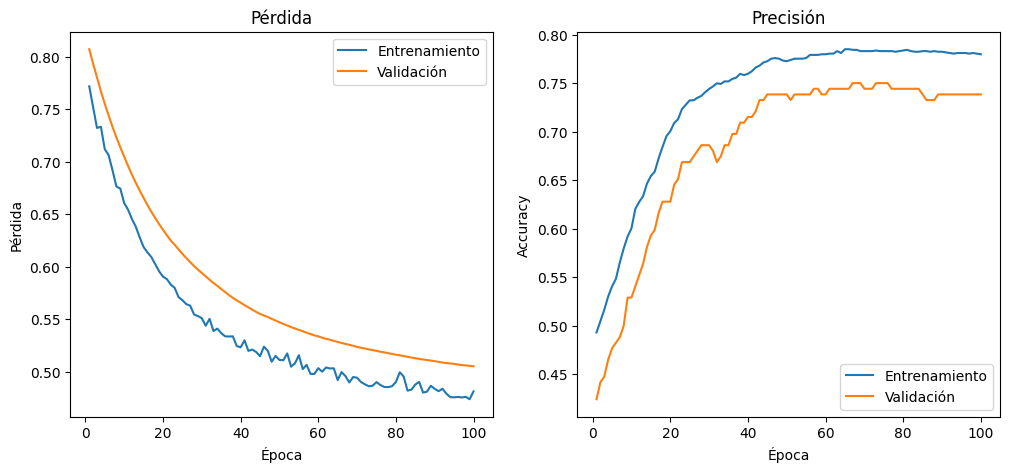

In [8]:
# Entrenamiento
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Ejecutar el ciclo de entrenamiento
    train_loss, train_acc = train_loop(dataloader_train, model, criterion, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Ejecutar el ciclo de validación
    val_loss, val_acc = test_loop(dataloader_val, model, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

# Graficar las pérdidas y accuracies
plt.figure(figsize=(12, 5))

# Gráfico de la pérdida
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Entrenamiento')
plt.plot(range(1, num_epochs+1), val_losses, label='Validación')
plt.title('Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico de la accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Entrenamiento')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validación')
plt.title('Precisión')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Modelo 3

In [9]:
class SimpleSigmoidNN(nn.Module):
    def __init__(self, features):
        super(SimpleSigmoidNN, self).__init__()
        self.linear = nn.Linear(features, 1)  # Una neurona, una salida
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))  # Activación sigmoide

In [10]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()  # Modo de entrenamiento
    train_loss = 0
    correct = 0

    for batch, (X, y) in enumerate(dataloader):
        # Forward pass
        pred = model(X).squeeze()  # Aplanar la salida para que sea un vector
        loss = loss_fn(pred, y)

        # Backward pass y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calcular métricas
        train_loss += loss.item()

        # Si pred contiene probabilidades, usamos 0.5 como umbral para clase binaria
        pred_class = (pred > 0.5).type(torch.float)  # Clase 1 si probabilidad > 0.5
        correct += (pred_class == y).type(torch.float).sum().item()

    # Promedio de pérdida y precisión
    train_loss /= len(dataloader)
    correct /= size
    return train_loss, correct

In [11]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()  # Modo de evaluación
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X).squeeze()  # Aplanar la salida para que sea un vector
            test_loss += loss_fn(pred, y).item()

            # Umbral de 0.5 para clasificación binaria
            pred_class = (pred > 0.5).type(torch.float)
            correct += (pred_class == y).type(torch.float).sum().item()

    # Promedio de pérdida y precisión
    test_loss /= num_batches
    correct /= size
    return test_loss, correct

In [12]:
# Escalar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)


dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
dataset_val = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 32
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

# Crear la red neuronal
model = SimpleSigmoidNN(X_train_tensor.shape[1])

# Definir la función de pérdida (entropía cruzada binaria) y el optimizador (SGD)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

Epoch [10/100], Loss: 0.7129, Train Accuracy: 0.5309, Val Loss: 0.6654, Val Accuracy: 0.5581
Epoch [20/100], Loss: 0.6607, Train Accuracy: 0.6023, Val Loss: 0.6294, Val Accuracy: 0.6337
Epoch [30/100], Loss: 0.6213, Train Accuracy: 0.6829, Val Loss: 0.6033, Val Accuracy: 0.6570
Epoch [40/100], Loss: 0.5905, Train Accuracy: 0.7186, Val Loss: 0.5835, Val Accuracy: 0.6744
Epoch [50/100], Loss: 0.5686, Train Accuracy: 0.7420, Val Loss: 0.5682, Val Accuracy: 0.6919
Epoch [60/100], Loss: 0.5501, Train Accuracy: 0.7511, Val Loss: 0.5559, Val Accuracy: 0.7093
Epoch [70/100], Loss: 0.5392, Train Accuracy: 0.7635, Val Loss: 0.5462, Val Accuracy: 0.7326
Epoch [80/100], Loss: 0.5251, Train Accuracy: 0.7706, Val Loss: 0.5381, Val Accuracy: 0.7267
Epoch [90/100], Loss: 0.5223, Train Accuracy: 0.7784, Val Loss: 0.5316, Val Accuracy: 0.7326
Epoch [100/100], Loss: 0.5115, Train Accuracy: 0.7836, Val Loss: 0.5261, Val Accuracy: 0.7442


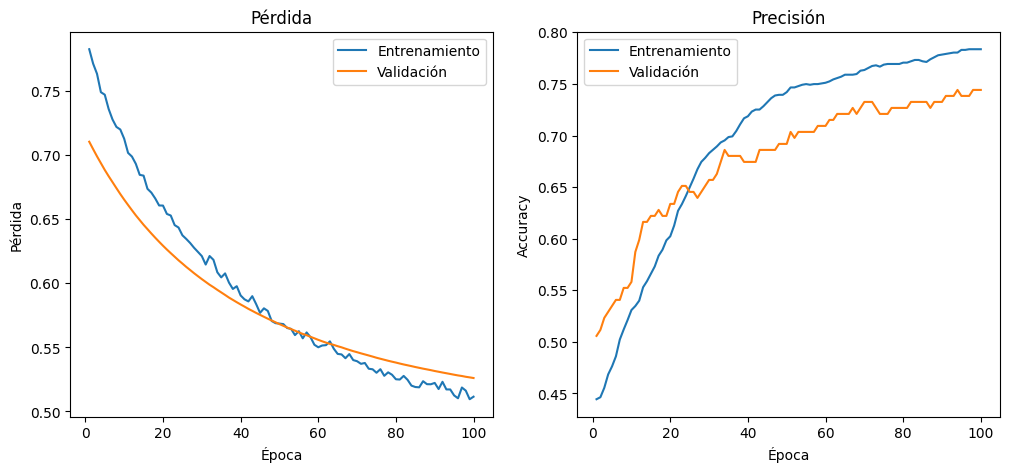

In [13]:
# Entrenamiento
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Ejecutar el ciclo de entrenamiento
    train_loss, train_acc = train_loop(dataloader_train, model, criterion, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Ejecutar el ciclo de validación
    val_loss, val_acc = test_loop(dataloader_val, model, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

# Graficar las pérdidas y accuracies
plt.figure(figsize=(12, 5))

# Gráfico de la pérdida
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Entrenamiento')
plt.plot(range(1, num_epochs+1), val_losses, label='Validación')
plt.title('Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico de la accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Entrenamiento')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validación')
plt.title('Precisión')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Modelo 4

In [14]:
class SigmoidNNWithHiddenLayer(nn.Module):
    def __init__(self, features):
        super(SigmoidNNWithHiddenLayer, self).__init__()
        self.hidden = nn.Linear(features, 16)   # Capa oculta con 16 unidades
        self.output = nn.Linear(16, 2)          # Capa de salida con 2 neuronas (para las dos clases)
    
    def forward(self, x):
        x = torch.sigmoid(self.hidden(x))
        x = torch.softmax(self.output(x), dim=1) # Softmax para obtener probabilidades
        return x

In [15]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()  # Modo de entrenamiento
    train_loss = 0
    correct = 0

    for batch, (X, y) in enumerate(dataloader):
        # Forward pass
        pred = model(X)  # La salida ya tiene forma (batch_size, 2)
        loss = loss_fn(pred, y)

        # Backward pass y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calcular métricas
        train_loss += loss.item()

        # Obtener la clase predicha (índice de la mayor probabilidad)
        pred_class = pred.argmax(dim=1)  # Clase con la mayor probabilidad
        correct += (pred_class == y).type(torch.float).sum().item()

    # Promedio de pérdida y precisión
    train_loss /= len(dataloader)
    correct /= size
    return train_loss, correct

In [16]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()  # Modo de evaluación
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)  # La salida ya tiene forma (batch_size, 2)
            test_loss += loss_fn(pred, y).item()

            # Obtener la clase predicha (índice de la mayor probabilidad)
            pred_class = pred.argmax(dim=1)  # Clase con la mayor probabilidad
            correct += (pred_class == y).type(torch.float).sum().item()

    # Promedio de pérdida y precisión
    test_loss /= num_batches
    correct /= size
    return test_loss, correct

In [17]:
# Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
dataset_val = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 32
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
# Crear la red neuronal
model = SigmoidNNWithHiddenLayer(X_train_tensor.shape[1])

# Definir la función de pérdida (entropía cruzada binaria) y el optimizador (SGD)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)

Epoch [10/100], Loss: 0.5528, Train Accuracy: 0.7570, Val Loss: 0.5685, Val Accuracy: 0.7326
Epoch [20/100], Loss: 0.5609, Train Accuracy: 0.7570, Val Loss: 0.5659, Val Accuracy: 0.7326
Epoch [30/100], Loss: 0.5624, Train Accuracy: 0.7570, Val Loss: 0.5612, Val Accuracy: 0.7326
Epoch [40/100], Loss: 0.5418, Train Accuracy: 0.7570, Val Loss: 0.5523, Val Accuracy: 0.7326
Epoch [50/100], Loss: 0.5339, Train Accuracy: 0.7667, Val Loss: 0.5436, Val Accuracy: 0.7500
Epoch [60/100], Loss: 0.5226, Train Accuracy: 0.7810, Val Loss: 0.5378, Val Accuracy: 0.7674
Epoch [70/100], Loss: 0.5259, Train Accuracy: 0.7849, Val Loss: 0.5348, Val Accuracy: 0.7616
Epoch [80/100], Loss: 0.5134, Train Accuracy: 0.7934, Val Loss: 0.5333, Val Accuracy: 0.7616
Epoch [90/100], Loss: 0.5108, Train Accuracy: 0.7953, Val Loss: 0.5325, Val Accuracy: 0.7616
Epoch [100/100], Loss: 0.5084, Train Accuracy: 0.7966, Val Loss: 0.5310, Val Accuracy: 0.7616


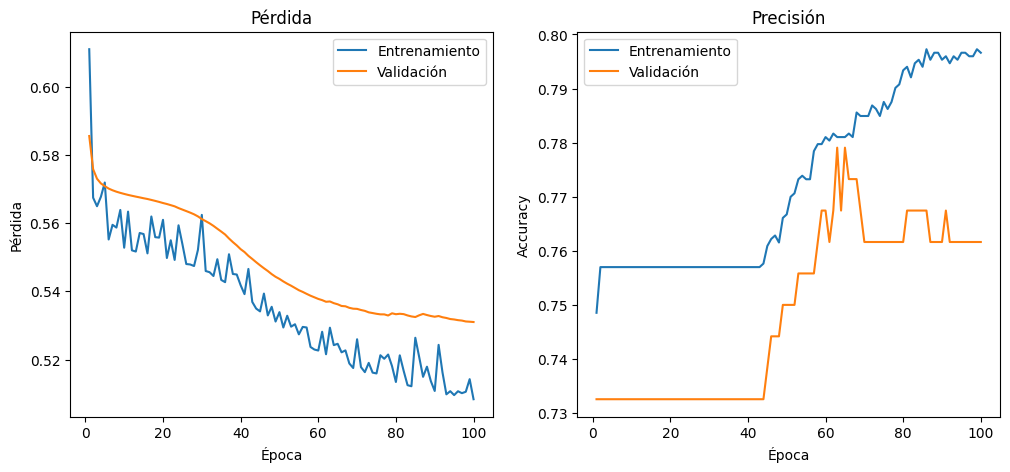

In [18]:
# Entrenamiento
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Ejecutar el ciclo de entrenamiento
    train_loss, train_acc = train_loop(dataloader_train, model, criterion, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Ejecutar el ciclo de validación
    val_loss, val_acc = test_loop(dataloader_val, model, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

# Graficar las pérdidas y accuracies
plt.figure(figsize=(12, 5))

# Gráfico de la pérdida
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Entrenamiento')
plt.plot(range(1, num_epochs+1), val_losses, label='Validación')
plt.title('Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico de la accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Entrenamiento')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validación')
plt.title('Precisión')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Modelo 5.A

La primer arquitectura que planteamos para intentar mejorar los resultados previamente obtenidos fue una red neuronal simple.

Esta red está compuesta por:

- Una capa de entrada lineal, que recibe el número de atributos a utilizar como de entrada y las transforma en 16 neuronas.

- Una función de activación LeakyReLU que se aplica después de la capa de entrada para añadir no linealidad y permitir que la red aprenda patrones más complejos.

- Un Dropout con probabilidad 0.4 después de la capa de entrada, que desactiva el 40% de las neuronas en cada paso para reducir el riesgo de sobreajuste.

- Una capa oculta lineal que recibe las 16 neuronas de la capa de entrada y las reduce a 8 neuronas para continuar el proceso de aprendizaje.

- Otra función de activación LeakyReLU que se aplica después de la capa oculta para introducir una segunda no linealidad en el modelo.

- Un segundo Dropout de probabilidad 0.4, que vuelve a desactivar el 40% de las neuronas en la capa oculta para mejorar la generalización.

- Una capa de salida lineal, que recibe las 8 neuronas de la capa oculta y produce una única salida que representa la probabilidad de una clase en un problema de clasificación binaria.

Esta arquitectura permite que la red clasifique las entradas en una de dos clases posibles (binaria), aplicando la función de pérdida BCEWithLogitsLoss, que calcula la pérdida con una activación sigmoide para obtener probabilidades en la salida.
Esta red se utilizó con el optimizador SGD, que se basa en el descenso por gradiente y con un paso de 0.05 de tasa de aprendizaje. Este paso fue definido tras probar con distintos valores y ver que el mejor desempeño se dió en este caso.

In [19]:
class NeuronalNetworkV1(nn.Module):
    def __init__(self, features):
        super(NeuronalNetworkV1, self).__init__()
        self.input_layer = nn.Linear(features, 16)
        self.hidden_activation = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.4)

        # Añadir más capas ocultas
        self.hidden_layer1 = nn.Linear(16, 8)
        
        self.output_layer = nn.Linear(8, 1)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_activation(x)
        x = self.dropout(x)

        x = self.hidden_layer1(x)
        x = self.hidden_activation(x)
        x = self.dropout(x)

        x = self.output_layer(x)
        return x

In [20]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()  # Modo de entrenamiento
    train_loss = 0
    correct = 0

    for batch, (X, y) in enumerate(dataloader):
        # Forward pass
        pred = model(X).squeeze()  # Aplanar la salida para que sea un vector
        loss = loss_fn(pred, y)

        # Backward pass y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calcular métricas
        train_loss += loss.item()

        # Convertimos los logits en probabilidades aplicando Sigmoid para la evaluación
        pred = torch.sigmoid(pred)  # Aplica sigmoid para obtener las probabilidades
        # Si pred contiene probabilidades, usamos 0.5 como umbral para clase binaria
        pred_class = (pred > 0.5).type(torch.float)  # Clase 1 si probabilidad > 0.5
        correct += (pred_class == y).type(torch.float).sum().item()

    # Promedio de pérdida y precisión
    train_loss /= len(dataloader)
    correct /= size
    return train_loss, correct

In [21]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()  # Modo de evaluación
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X).squeeze()  # Aplanar la salida para que sea un vector
            test_loss += loss_fn(pred, y).item()

            # Convertimos los logits en probabilidades aplicando Sigmoid para la evaluación
            pred = torch.sigmoid(pred)  # Aplica sigmoid para obtener las probabilidades
            # Umbral de 0.5 para clasificación binaria
            pred_class = (pred > 0.5).type(torch.float)
            correct += (pred_class == y).type(torch.float).sum().item()

    # Promedio de pérdida y precisión
    test_loss /= num_batches
    correct /= size
    return test_loss, correct

In [22]:
# Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)


dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
dataset_val = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 32
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

# Crear la red neuronal
model = NeuronalNetworkV1(X_train_tensor.shape[1])

# Definir la función de pérdida (entropía cruzada binaria) y el optimizador (SGD)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)

Epoch [10/100], Loss: 0.5206, Train Accuracy: 0.7680, Val Loss: 0.5232, Val Accuracy: 0.7267
Epoch [20/100], Loss: 0.5102, Train Accuracy: 0.7869, Val Loss: 0.4935, Val Accuracy: 0.7674
Epoch [30/100], Loss: 0.4929, Train Accuracy: 0.7869, Val Loss: 0.4881, Val Accuracy: 0.7616
Epoch [40/100], Loss: 0.4926, Train Accuracy: 0.7719, Val Loss: 0.4767, Val Accuracy: 0.7616
Epoch [50/100], Loss: 0.4842, Train Accuracy: 0.7719, Val Loss: 0.4752, Val Accuracy: 0.7616
Epoch [60/100], Loss: 0.4731, Train Accuracy: 0.7778, Val Loss: 0.4670, Val Accuracy: 0.7558
Epoch [70/100], Loss: 0.4773, Train Accuracy: 0.7901, Val Loss: 0.4691, Val Accuracy: 0.7791
Epoch [80/100], Loss: 0.4563, Train Accuracy: 0.7921, Val Loss: 0.4763, Val Accuracy: 0.7674
Epoch [90/100], Loss: 0.4625, Train Accuracy: 0.7849, Val Loss: 0.4687, Val Accuracy: 0.7849
Epoch [100/100], Loss: 0.4606, Train Accuracy: 0.7986, Val Loss: 0.4653, Val Accuracy: 0.7907


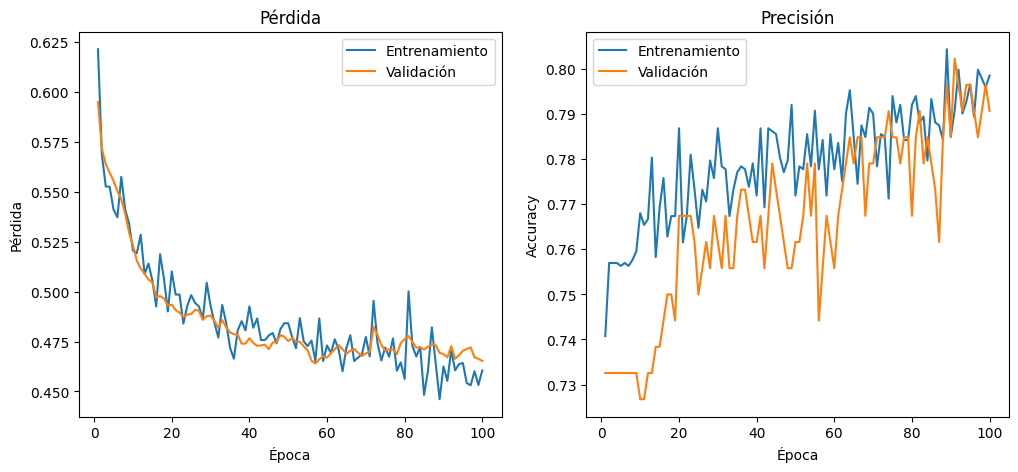

In [23]:
# Entrenamiento
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Ejecutar el ciclo de entrenamiento
    train_loss, train_acc = train_loop(dataloader_train, model, criterion, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Ejecutar el ciclo de validación
    val_loss, val_acc = test_loop(dataloader_val, model, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

# Graficar las pérdidas y accuracies
plt.figure(figsize=(12, 5))

# Gráfico de la pérdida
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Entrenamiento')
plt.plot(range(1, num_epochs+1), val_losses, label='Validación')
plt.title('Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico de la accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Entrenamiento')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validación')
plt.title('Precisión')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 3. Experimentación

- Presentar los distintos experimentos que se realizan y los resultados que se obtienen.

- La información de los resultados se presenta en tablas y en gráficos, de acuerdo a su naturaleza. Por ejemplo:

_En la gráfica 1, se observa el error cuadrático total del conjunto de entrenamiento a medida que pasan los juegos para el oponente X_

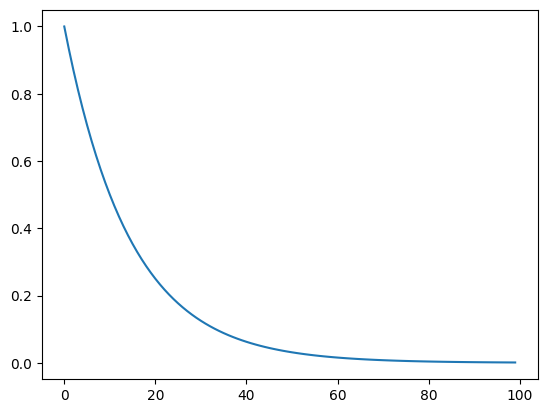

In [24]:
import matplotlib.pyplot
matplotlib.pyplot.plot(range(0,100), [2**-(x/10) for x in range(0,100)])


- Debe existir alguna instancia donde se compile la información relevante de los experimentos de forma de poder comparar fácilmente los distintos experimentos. Por ejemplo:

_En la tabla 1, se presentan los distintos resultados contra el jugador aleatorio, para los distintos valores de $\alpha$ elegidos. El mejor resultado se obtiene para $\alpha=0.05$, lo que prueba que la estrategia..._

<table>
  <tr>
    <th>$\alpha$</th>
    <th>...</th>
    <th>Turnos</th>
    <th>Error</th>
  </tr>
  <tr>
    <td>0.001</td>
    <td>...</td>
    <td>100</td>
    <td>0.991</td>
  </tr>    
  <tr>
    <td>0.005</td>
    <td>...</td>
    <td>100</td>
    <td>0.987</td>
  </tr>
  <tr style="font-weight:bold">
    <td>0.05</td>
    <td>...</td>
    <td>100</td>
    <td>0.329</td>
  </tr>
  <tr>
    <td>0.5</td>
    <td>...</td>
    <td>100</td>
    <td>0.564</td>
  </tr>    
    <caption>Tabla 1 - Entrenamiento del jugador X para distintos valores de $\alpha$</caption>
</table>


## 4. Conclusión

Una breve conclusión del trabajo realizado. Por ejemplo: 
- ¿cuándo se dieron los mejores resultados del jugador?
- ¿encuentra alguna relación con los parámetros / oponentes/ atributos elegidos?
- ¿cómo mejoraría los resultados?